In [291]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit
import scipy as sp
from itertools import combinations

import os


import jax
import jax.numpy as jnp
from jax import random, jit
from jax.scipy.special import expit, logsumexp
from functools import partial
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
from numpyro.util import set_host_device_count
from numpyro.contrib.control_flow import scan
from numpyro.ops.indexing import Vindex
from tqdm import tqdm
from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
import pymc_experimental as pmx

import multiprocessing
import socket

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


Running on PyMC v5.10.4
Running on PyMC-experimental v0.0.17
Running on NumPyro v0.14.0
Running on Pyro v1.9.0+f02dfb9
Running on JAX v0.4.25


In [2]:
# Set CPU for JAX
# nchains = multiprocessing.cpu_count()/2
# print("nchains in total are", nchains*2, "; we'll use ", nchains)


# jax.config.update('jax_platform_name', 'cpu')
# platform = jax.lib.xla_bridge.get_backend().platform.casefold()
# print("Platform: ", platform)
# host_name = socket.gethostname()
# localhost_ = socket.gethostbyname(host_name)
# print(localhost_)

# jax.distributed.initialize(coordinator_address="localhost", num_processes=4, process_id=1)
# print(jax.device_count())
# print(jax.local_device_count())

# set_host_device_count(nchains)
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))




[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [3]:
RANDOM_SEED = 892357143
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

(array([1.3341e+04, 1.1513e+04, 8.6060e+03, 5.6440e+03, 3.2020e+03,
        1.5890e+03, 6.4500e+02, 2.4000e+02, 6.4000e+01, 6.0000e+00]),
 array([4.29458077e-05, 1.68656179e+00, 3.37308064e+00, 5.05959948e+00,
        6.74611833e+00, 8.43263718e+00, 1.01191560e+01, 1.18056749e+01,
        1.34921937e+01, 1.51787126e+01, 1.68652314e+01]),
 <BarContainer object of 10 artists>)

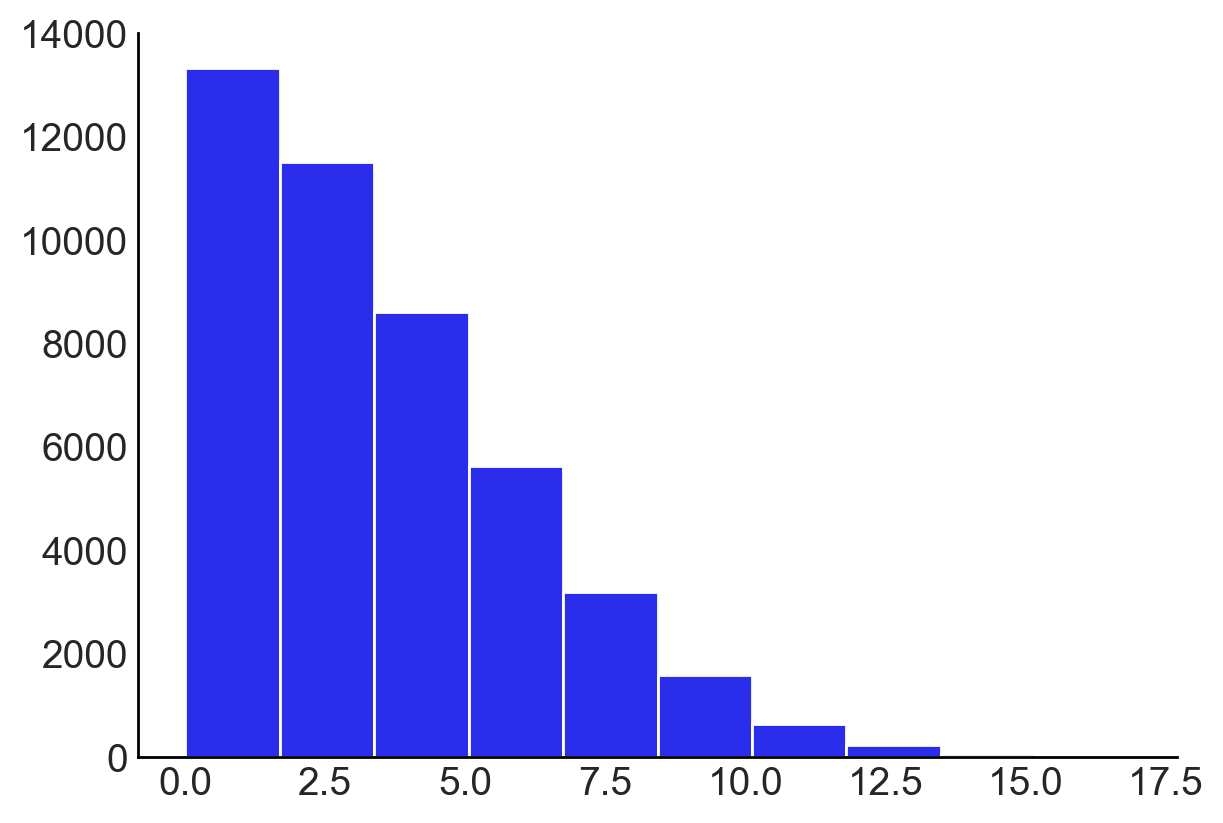

In [150]:
n=300
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
# x = rng.uniform(size=n,low=-3,high=3)
# x = rng.standard_t(size=n,df=5)
# x2 = rng.binomial(n=1,p=0.25,size=n)

# x_diff = []
# # x2_equal =[]
# for i in range(n):
#     for j in range(i+1,n):
#         x_diff.append(np.abs(x[i]-x[j]))
#         # x2_equal.append(x2[i]==x2[j])
# x_diff = np.array(x_diff)
# x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
# beta = -2, -.5

idx_pairs = combinations(range(len(x)),2)
x_diff = np.array([abs(x[i] - x[j]) for i, j in idx_pairs])


plt.figure(figsize=(5,3))
plt.hist(x_diff)


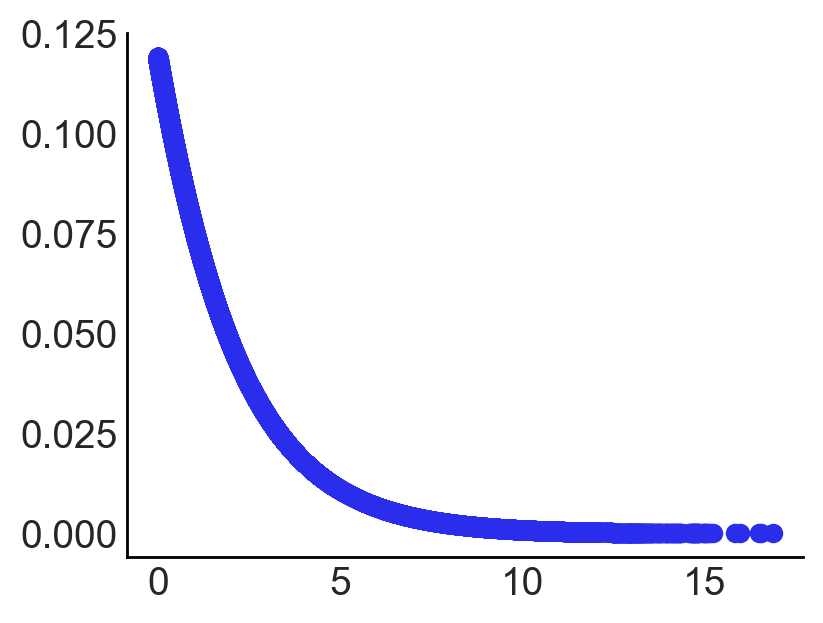

In [163]:
beta = -2, -0.5
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
probs = expit(beta[0] + beta[1]*x_diff)

plt.figure(figsize=(4,3))
plt.scatter(x_diff,probs)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]





In [343]:
def eigen_centrality(adj_mat):
    sparse_mat = sp.sparse.csr_matrix(adj_mat)
    _, eig_vec = sp.sparse.linalg.eigs(sparse_mat, k=1, which = 'LR')
    largest_v = eig_vec.flatten().real
    norm = np.sign(largest_v.sum()) * sp.linalg.norm(largest_v)
    return largest_v / norm




(array([26., 36., 43., 59., 48., 44., 29.,  9.,  3.,  3.]),
 array([3.41487902e-18, 1.34192304e-02, 2.68384608e-02, 4.02576912e-02,
        5.36769216e-02, 6.70961520e-02, 8.05153824e-02, 9.39346128e-02,
        1.07353843e-01, 1.20773074e-01, 1.34192304e-01]),
 <BarContainer object of 10 artists>)

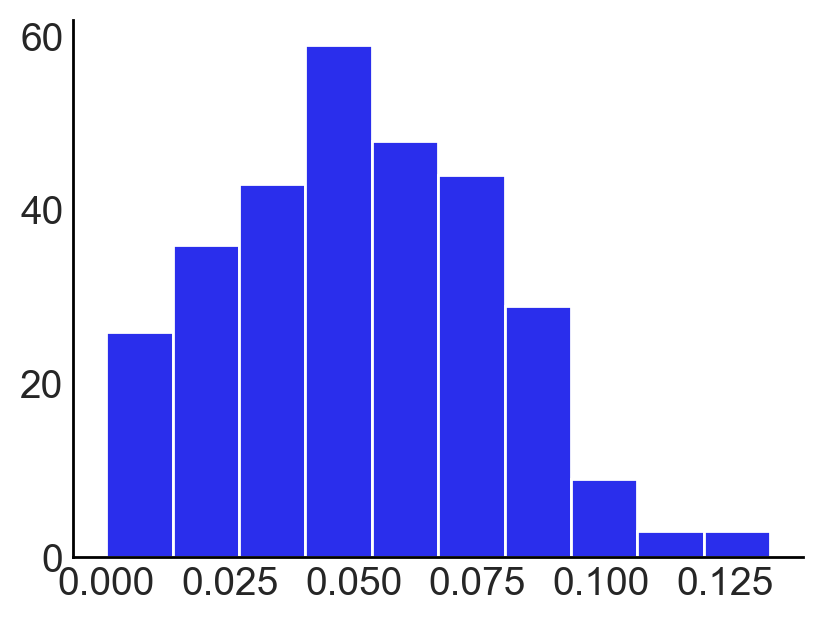

In [344]:
eigen_center = eigen_centrality(mat)
plt.figure(figsize=(4,3))
plt.hist(eigen_center)


In [345]:
# mat_net = nx.from_numpy_array(mat)
# 
# degrees = np.array([degree for _, degree in mat_net.degree()])
# deg_center = np.array(list(nx.degree_centrality(mat_net).values()))
# eigen_center = np.array(list(nx.eigenvector_centrality_numpy(mat_net).values()))
# closeness = np.array(list(nx.closeness_centrality(mat_net).values()))
# betweeness = np.array(list(nx.betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.current_flow_betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.approximate_current_flow_betweenness_centrality(mat_net,epsilon=0.1).values()))
# triangles = np.array(list(nx.triangles(mat_net).values()))
# clustering = np.array(list(nx.clustering(mat_net).values()))


In [346]:
# plt.figure(figsize=(5,3))
# np.array(list(eigen_center)).shape
# plt.hist(degrees)
# plt.hist(triangles)
# plt.hist(clustering)
# plt.hist(closeness)
# plt.hist(flow_betweeness)
# plt.hist(betweeness)
# plt.hist(closeness*triangles)
# plt.scatter(deg_center,degrees)
# plt.scatter(degrees,closeness)
# plt.scatter(betweeness,closeness)
# plt.scatter(betweeness,flow_betweeness)
# plt.scatter(triangles,flow_betweeness)
# plt.scatter(app_flow_betweeness,flow_betweeness)
# plt.scatter(triangles,closeness)
# plt.scatter(triangles,betweeness)
# plt.scatter(betweeness,degrees)
# plt.scatter(betweeness,triangles)
# plt.scatter(triangles,degrees)
# plt.scatter(triangles,betweeness)
# plt.scatter(triangles,eigen_center)
# plt.scatter(manual_eig_center,eigen_center)

In [347]:
# print(min(betweeness),max(betweeness))
# print(min(eigen_center),max(eigen_center))
# print(min(triangles),max(triangles))


In [348]:
np.dot(np.transpose(np.array([[1]*n,x])),[2,3])

array([ 9.84113989e+00, -2.61899315e+00, -6.03811694e+00,  1.36374062e+01,
        5.91632139e+00,  2.48010613e+01,  6.24770691e+00,  7.33447753e+00,
        5.84140722e+00, -2.03361713e+01,  4.19854892e+00, -3.18128119e-01,
       -3.21228408e+00, -3.02971458e+00,  2.21485293e+01,  9.46562857e+00,
       -6.12503042e+00, -5.34298063e-01,  1.35683160e+01, -3.75083736e+00,
       -5.44941886e+00,  3.07131028e+00, -3.10174083e+00,  2.15155238e+00,
        5.01503961e-01, -1.38576464e+01,  1.17107191e+01,  1.56613973e+01,
        5.53205130e+00, -1.39523656e+01,  5.10998085e+00, -2.09762192e+00,
        1.68682897e+00,  1.03735028e+01,  2.59229260e+00,  6.08121256e+00,
        6.78767808e+00,  7.93350445e+00, -4.37845044e+00, -1.79236660e+00,
        4.00264539e+00, -1.30416452e+01,  6.62607735e+00, -1.16549565e+01,
       -1.08771262e+01,  6.71026422e+00,  5.53146616e+00, -2.95248870e+00,
        9.69275808e+00,  6.07179849e+00, -3.95452308e+00, -1.25273264e+01,
       -7.60276426e+00,  

                0
count  300.000000
mean     3.450000
std      1.985103
min      0.000000
25%      2.000000
50%      3.000000
75%      5.000000
max     10.000000
                0
count  299.000000
mean    -0.091152
std      1.996344
min     -7.984542
25%     -1.470969
50%     -0.108523
75%      1.143053
max      5.960947
                0
count  300.000000
mean    -0.111210
std      3.124540
min     -9.264878
25%     -1.993826
50%     -0.058421
75%      1.896184
max      7.600354


C:\Users\bar21\AppData\Local\Temp\ipykernel_9508\4086272414.py:7: RuntimeWarning: invalid value encountered in divide
  x_neighbors = np.dot(mat,x) / degrees


(array([ 3., 15., 39., 70., 62., 42., 35., 24.,  6.,  4.]),
 array([-4.10829218, -3.11718037, -2.12606856, -1.13495675, -0.14384494,
         0.84726687,  1.83837868,  2.82949049,  3.82060229,  4.8117141 ,
         5.80282591]),
 <BarContainer object of 10 artists>)

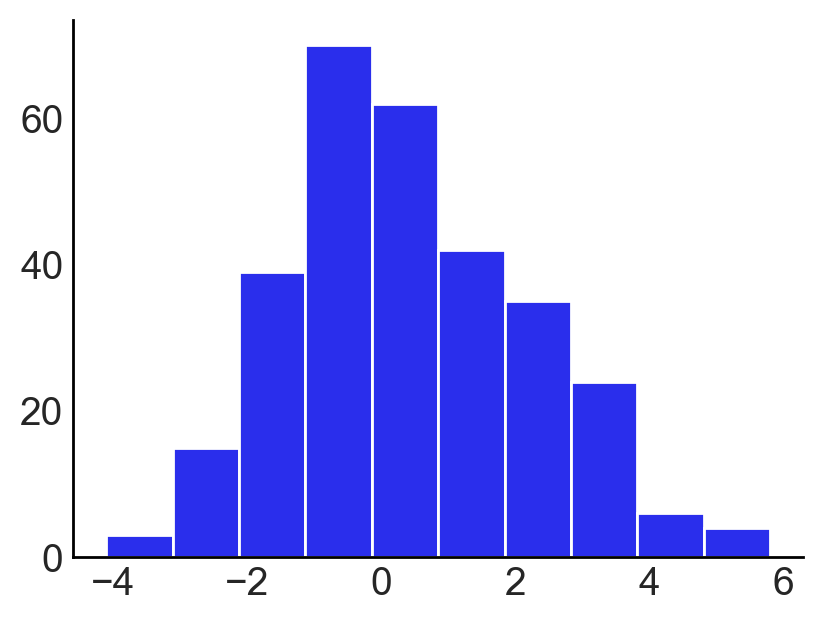

In [349]:
# Create outcome data

Z = rng.binomial(n=1,p=0.3,size=n)
exposures = np.dot(mat,Z)  
degrees = np.sum(mat,1)
print(pd.DataFrame(exposures).describe())
x_neighbors = np.dot(mat,x) / degrees
print(pd.DataFrame(x_neighbors).describe())
print(pd.DataFrame(x).describe())

Zeigen = np.dot(mat, Z*eigen_center)

# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
# alpha = -1, 3, 2, -.25, 5, 5 
alpha = -1, 3, 2.5, -.25 

# df_array = np.transpose(np.array([[1]*n,Z,exposures,x,eigen_center,betweeness]))
df_array = np.transpose(np.array([[1]*n, Z, Zeigen, x]))
mean_y = np.dot(df_array,alpha)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + alpha[4] + rng.normal(loc=0,scale=1,size=n)
Y = mean_y + rng.normal(loc=0,scale=1,size=n)

plt.figure(figsize=(4,3))
plt.hist(Y)


[[1.         0.78455242]
 [0.78455242 1.        ]]


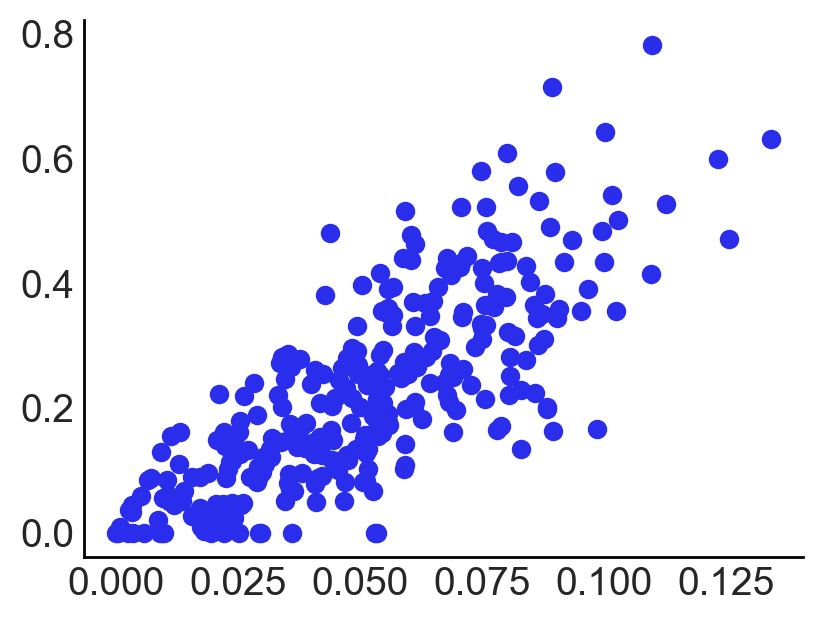

In [350]:
plt.figure(figsize=(4,3))
# plt.scatter(exposures,betweeness)
# plt.scatter(exposures,eigen_center)

print(np.corrcoef(eigen_center,Zeigen))
plt.scatter(eigen_center,Zeigen)
# plt.scatter(exposures,Zeigen)
# plt.scatter(exposures/degrees,Zeigen)
# plt.scatter(betweeness,eigen_center)
# plt.hist(Zeigen)
# plt.hist(exposures/degrees)

In [351]:
# DG = nx.from_numpy_array(mat)
# nx.set_node_attributes(DG, Z, "Treatments") 
# nx.draw(DG, with_labels=True,  node_color = Z)
# plt.legend()
# plt.show()

In [352]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
gamma0 = 0.05 # add non-existing edge with prob `bet` 

obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
for i in range(0,n): # add noise
    for j in range(i+1,n):
        if mat[i,j] == 1:
            obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
        else:
            obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
            
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


(array([ 3.,  9., 24., 37., 74., 65., 23., 31., 25.,  9.]),
 array([ 9. , 11.7, 14.4, 17.1, 19.8, 22.5, 25.2, 27.9, 30.6, 33.3, 36. ]),
 <BarContainer object of 10 artists>)

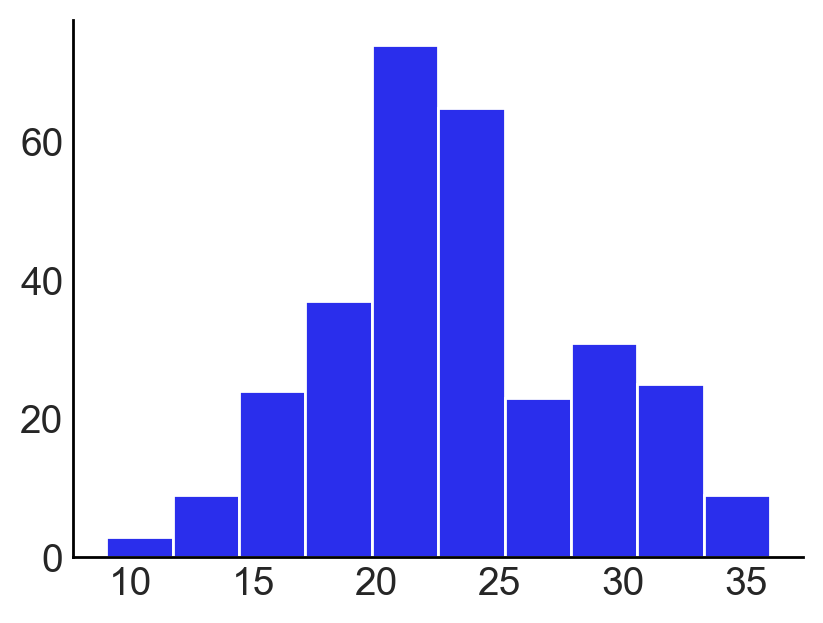

In [353]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.figure(figsize=(4,3))
plt.hist(np.sum(obs_mat,1))

In [354]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs'])


obs,0.0,1.0
true,,
0.0,40933,2147
1.0,446,1324


                0
count  300.000000
mean     6.496667
std      2.542611
min      1.000000
25%      5.000000
50%      6.000000
75%      8.000000
max     15.000000
Corr obs~true exposures:  0.5698216212735466
Corr obs~true Zeigen:  0.5592535146908194


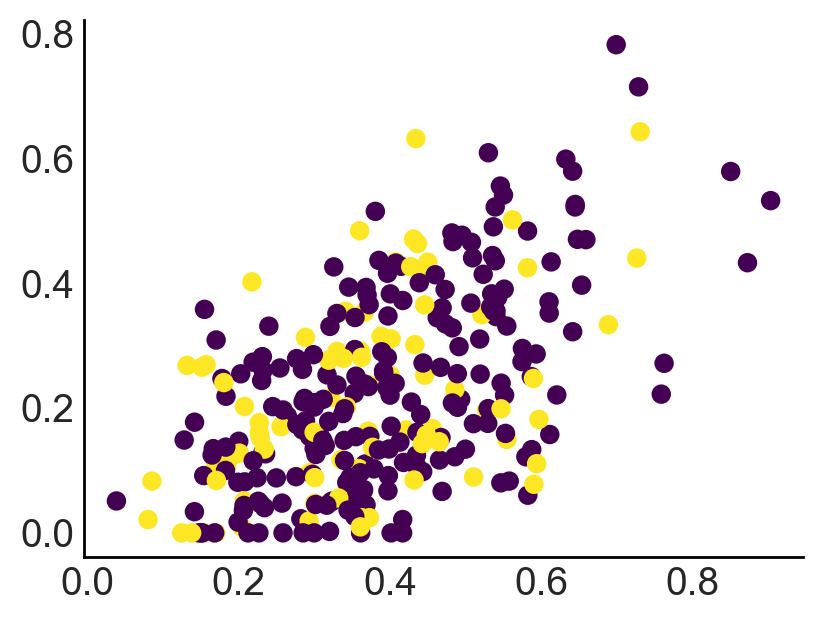

In [355]:

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)


# obs_net = nx.from_numpy_array(obs_mat)
# obs_deg = np.array([degree for _, degree in obs_net.degree()])
# obs_betweeness = np.array(list(nx.betweenness_centrality(obs_net).values()))
# obs_triangles = np.array(list(nx.triangles(obs_net).values()))
# obs_eigen_center = np.array(list(nx.eigenvector_centrality_numpy(obs_net).values()))
obs_eigen_cent = eigen_centrality(obs_mat)
obs_exposures = np.dot(obs_mat,Z)
obs_Zeigen = np.dot(obs_mat, Z*obs_eigen_cent)

# obs_df = np.transpose(np.array([[1]*n, Z, obs_exposures,x, obs_eigen_center, obs_betweeness]))
obs_df = np.transpose(np.array([[1]*n, Z, obs_Zeigen,x]))

print(pd.DataFrame(obs_exposures).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])
print("Corr obs~true Zeigen: ", np.corrcoef(Zeigen, obs_Zeigen)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
plt.figure(figsize=(4,3))
# plt.scatter(obs_exposures,exposures, c=Z)
plt.scatter(obs_Zeigen,Zeigen, c=Z)

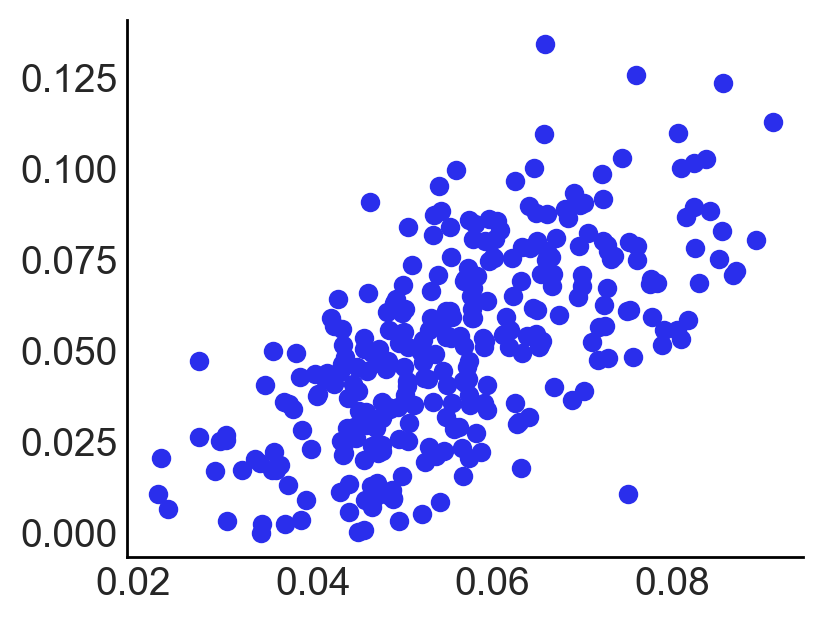

In [356]:
plt.figure(figsize=(4,3))
# plt.scatter(obs_betweeness, betweeness)
plt.scatter(obs_eigen_cent, eigen_center)

In [12]:
# with pm.Model() as model_obs_mat:
#       # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     # obs_tril = pm.ConstantData("obs_tril", tril_obs)
#     obs_triu = pm.ConstantData("obs_triu", triu_obs)
#     expos = pm.ConstantData("expos", obs_exposures)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob, observed=obs_triu)
#     # tril = pm.Bernoulli("tril", p=prob, observed=obs_tril)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     mu_y = alpha0 + alpha1*z + alpha2*expos +  alpha3*z*expos 
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#       
# pm.model_to_graphviz(model_obs_mat)

In [13]:
# def triu_vals_to_mat(triu_vals, n):
#     # Z_val = Z.eval()
#     triu_vals_ = triu_vals.eval()
#     AM = np.zeros((n,n))
#     AM[np.triu_indices(n=n,k=1)] = triu_vals_
#     # AM[np.tril_indices(n=n,k=-1)] = tril_vals_
#     # AM = AM + AM.T 
#     return AM + AM.T 
#     # return np.dot(AM,Z_val)/np.sum(AM,1)
#     
# # def get_network_miss_prob(tril_vals, gamma0, gamma1):
# #     tril_vals = tril_vals.eval()
# #     obs_tril_prob = 
# 
# with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
#     
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     obs_triu = pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)
#     
#     # Generate net stats
#     A_mat = triu_vals_to_mat(triu,n)
#     expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     deg = pm.Deterministic("deg", pm.math.sum(A_mat,1))
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=5)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=5)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=5)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     sig_y = pm.Exponential("sig_y",lam=.5)
#     mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*deg
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# pm.model_to_graphviz(model)    

In [14]:
# with model:
#     step1 = pm.Metropolis([beta0, beta1, Gamma0, Gamma1, alpha0, alpha1, alpha2, alpha3, sig_y])
#     step2 = pm.BinaryMetropolis([triu])
#     MH_step = pm.CompoundStep([step2, step1])
#     trace = pm.sample(draws=5000, tune=3000, chains=4, cores=4, step=MH_step)
#     # trace = pm.sample(draws=4000, tune=2000, chains=4, cores=4)
#     

In [15]:
# az.summary(trace)

In [16]:
# az.plot_trace(trace)


In [17]:
# with pmx.MarginalModel() as marg_model:      
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     # z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     # y = pm.ConstantData("Y_",Y)
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)  
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)   
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)    
#     # logit model of edges
#     # mu = beta0 + beta1*x + u 
#     # prob = pm.math.invlogit(mu)
#     # Ltri_A_mat = pm.Bernoulli("
#     
#     # Get exposures
#     # expos = tril_vals_to_exposures(obs_tril, z, n)
#     # Lower tri to adj. matrix
#     # A_mat = tril_vals_to_mat(obs_tril,n)
#     # A_mat = triu_vals_to_mat(triu,n)
#     # degress = pm.math.sum(A_mat,1)
#     # sum_expos = pm.math.dot(A_mat,z)
#     # expos = pm.Deterministic("expos", pm.math.switch(pt.tensor.eq(degress,0),0,sum_expos/degress))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z)/pm.math.sum(A_mat,1))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     # # Outcome model
#     # alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     # alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     # alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     # alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     # # alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     # sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*(expos**2)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*z*expos 
#     # Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# marg_model.marginalize(["triu"])
# pm.model_to_graphviz(marg_model)    

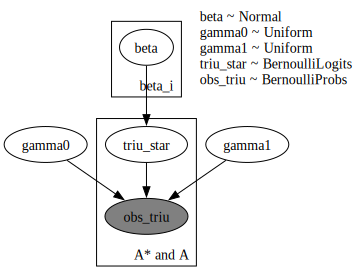

In [357]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_utri = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_utri].set(triu) 
    return adj_mat + adj_mat.T

@config_enumerate
def network_model(X, TriU, n):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,10))
    mu_net = beta[0] + beta[1]*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", triu_n):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 


# def outcome_model(Y,Z,X,A,n):
def outcome_model(Y,X):
    with numpyro.plate("alpha_i",X.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # sig = numpyro.sample("sig",dist.HalfNormal(scale=5))
    sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    # expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    mu_y = jnp.dot(X, alpha)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("n",n):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)

# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff,triu_obs,n), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))
# TODO: Check different samplers in NumPyro (e.g., HMCwithGibbs, M-HMC, marginalization); They are probably slow, check their runtime and ESS (e.g., in comparison to PyMC).
# TODO: Replace `for` loop with `enumerate`; use `scan` function (see NumPyro HMM guide https://num.pyro.ai/en/stable/examples/hmm_enum.html) see also https://pyro.ai/examples/enumeration.html
# TODO: see also this numpyro guidebook (``rethinking") https://fehiepsi.github.io/rethinking-numpyro/

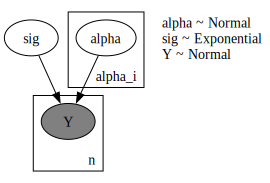

In [358]:
# numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)
numpyro.render_model(outcome_model, model_args=(Y,df_array), render_distributions=True)

In [359]:
# A* and A|A* models

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model, dense_mass=True)
kernel_network = NUTS(network_model)
mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -1.86      0.25     -1.87     -2.24     -1.45   4851.98      1.00
   beta[1]     -0.56      0.07     -0.56     -0.66     -0.45   5942.99      1.00
    gamma0      0.05      0.00      0.05      0.05      0.05   6014.11      1.00
    gamma1      0.26      0.14      0.27      0.06      0.50   4918.37      1.00

Number of divergences: 0
368.8671796321869


In [360]:
# Outcome model with A* (true network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.run(rng_key_,Y=Y,X=df_array)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.99      0.10     -0.99     -1.16     -0.82   9105.84      1.00
  alpha[1]      3.01      0.12      3.01      2.80      3.21  12280.29      1.00
  alpha[2]      2.33      0.36      2.33      1.76      2.93  10077.18      1.00
  alpha[3]     -0.24      0.02     -0.24     -0.27     -0.21  14482.63      1.00
       sig      0.97      0.04      0.96      0.90      1.03  13449.06      1.00

Number of divergences: 0
7.214995384216309


In [361]:
# Outcome model with A (observed network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
mcmc_network_obs.run(rng_key_,Y=Y, X=obs_df)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.79      0.17     -0.80     -1.06     -0.50   9045.88      1.00
  alpha[1]      3.00      0.13      3.00      2.79      3.22  14251.54      1.00
  alpha[2]      0.86      0.39      0.86      0.19      1.47   9547.73      1.00
  alpha[3]     -0.25      0.02     -0.25     -0.28     -0.22  16441.53      1.00
       sig      1.02      0.04      1.02      0.96      1.09  15102.82      1.00

Number of divergences: 0
5.690532207489014


In [362]:
print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

['beta_0 = -2', 'beta_1 = -0.5'] gamma0: 0.05 gamma1: 0.25
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 2.5', 'alpha_3 = -0.25'] sig: 1


In [363]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)
a_star_pred = Predictive(model=network_model, posterior_samples=post_pred_mean, infer_discrete=True,num_samples=1)
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

(16000, 2)
(16000,)
{'beta': Array([[-1.8562788, -0.5597934]], dtype=float32), 'gamma0': Array([0.04975481], dtype=float32), 'gamma1': Array([0.2649596], dtype=float32)}
(1, 44850)
(1, 44850)
False


sec,0,1
first,,
0,41914,1145
1,1110,681


In [364]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
post_predictive = post_predictive(rng_key, X=x_diff,TriU=triu_obs,n=n)
samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

(16000, 44850)
(44850,)


In [368]:
NN = n

@jax.jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # adj_mat = np.zeros((NN,NN))
    # obs_mat[np.triu_indices(n=NN,k=1)] = triu_v
    idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T

#     AM = np.zeros((NN,NN))
#     AM[np.triu_indices(n=NN,k=1)] = triu_v
#     return AM + AM.T 
# 
# 
# print(np.triu_indices(n=NN,k=1))
# print(a_star_pred1["triu_star"].shape)
# print(a_star_pred1["triu_star"][0])
# 
# st = time.time()
# for i in range(10000):
#     A1 = triu_to_mat(a_star_pred1["triu_star"], n)
# print("Regular takes: ", time.time() - st)

st = time.time()
for i in range(100):
    A2 = Triu_to_mat(a_star_pred1["triu_star"][i])
print("jax.jit takes: ", time.time() - st)

# np.array(Triu_to_mat(a_star_pred1["triu_star"][0])).shape

# print(np.array_equal(A1,A2))


jax.jit takes:  0.36752772331237793


(300, 300)
True expos~Y corr: 0.6059657359900121
Pred1 expos~Y corr: 0.2723033696794489
Pred2 expos~Y corr: 0.34109431351118774
obs expos~Y corr: 0.29609561306051313


Text(0, 0.5, 'True')

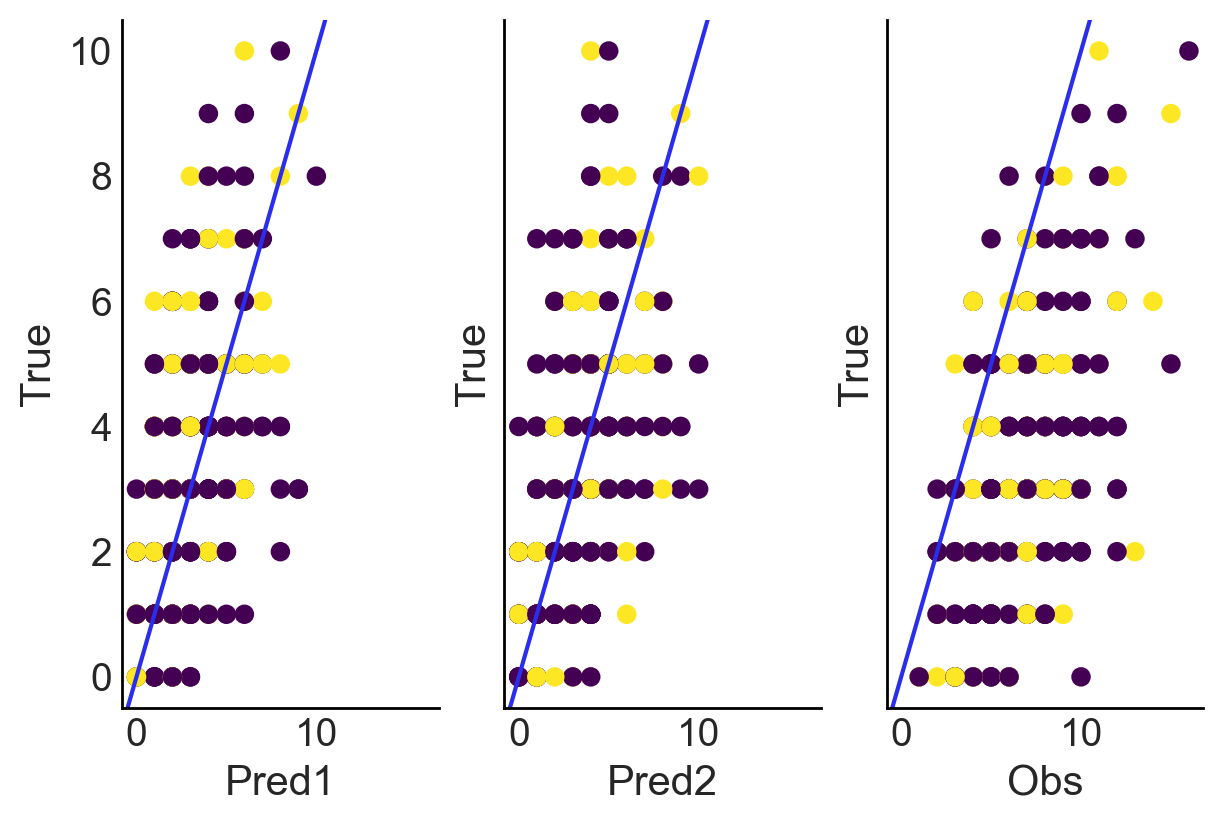

In [217]:

A_star_pred = Triu_to_mat(a_star_pred1["triu_star"][0])
A_star_pred2 = Triu_to_mat(a_star_pred2["triu_star"][0])
# A_star_pred = triu_to_mat(a_star_pred1["triu_star"],n)
# A_star_pred2 = triu_to_mat(a_star_pred2["triu_star"],n)
print(A_star_pred.shape)
# print(A_star_pred)


a_star_pred_deg = np.sum(A_star_pred,1)
a_star_pred_deg2 = np.sum(A_star_pred2,1)
a_star_sum_expos = np.dot(A_star_pred,Z) 
a_star_sum_expos2 = np.dot(A_star_pred2,Z)

Pred_expos1 = np.where(np.equal(a_star_pred_deg,0),0,a_star_sum_expos/a_star_pred_deg)
Pred_expos2 = np.where(np.equal(a_star_pred_deg2,0),0,a_star_sum_expos2/a_star_pred_deg2)

print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])
print("Pred1 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos)[1,0])
print("Pred2 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos2)[1,0])
print("obs expos~Y corr:",np.corrcoef(Y,obs_exposures)[1,0])


fig, axes = plt.subplots(nrows=1,ncols=3, sharex=True, sharey=True, figsize = (6,4))
ax1, ax2, ax3 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(a_star_sum_expos, exposures,c = Z+1, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(a_star_sum_expos2, exposures,c = Z+1, marker = 'o')
ax2.axline((0,0),slope=1)
ax3.scatter(obs_exposures, exposures,c = Z+1, marker = 'o')
ax3.axline((0,0),slope=1)
ax1.set_xlabel("Pred1")
ax2.set_xlabel("Pred2")
ax3.set_xlabel("Obs")
ax1.set_ylabel("True")
ax2.set_ylabel("True")
ax3.set_ylabel("True")
# ax.axline((0,0),slope=1)
# ax.set_xlabel("Obs")
# ax.set_ylabel("True")
# plt.show()

In [267]:
# np.array(a_star_pred1["triu_star"][0]).shape
nx.from_numpy_array(Triu_to_mat(a_star_pred1["triu_star"][0]))

In [411]:
# @partial(jit, static_argnums=1)
# @jax.jit
def compute_net_stats(adj_mat, Z):
    expos = jnp.dot(adj_mat, Z)
    net = nx.from_numpy_array(adj_mat)
    eigen_cen = jnp.array(list(nx.eigenvector_centrality_numpy(net).values()))
    betweeness = jnp.array(list(nx.betweenness_centrality(net).values()))
    return expos, eigen_cen, betweeness
    
# Two-stage with mean posterior of A* and A|A* parameters
def twostage_estimator(MCMC_obj, a_star_pred, Y, Z, X, x_diff, triu_obs, n,i):
    
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=n)
    # curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
    curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
   
    # pred_exp = np.dot(curr_Astar, Z)
    # print("Pred expos~Y corr:",np.corrcoef(Y,pred_exp)[1,0])
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i),Y=Y,Z=Z,X=X, A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()
    
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
    # return xr.DataArray(converted_post_samp)


NN = n

@jax.jit
# def get_samples(key, Y, Z, X, A ,n_warmup=500, n_samples=250, n_chains=2):
def get_samples(key, Y, df, n_warmup=500, n_samples=250, n_chains=2):
    kernel_outcome = NUTS(outcome_model)
    mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False)
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    mcmc.run(key, Y=Y, X=df)
    return mcmc.get_samples()

def twostage_jj(a_star_pred, Y, Z, X, x_diff, triu_obs, i):
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=NN)
    # curr_Astar = triu_to_mat(curr_Astar["triu_star"],NN)
    curr_Astar = Triu_to_mat(curr_Astar["triu_star"][0])
    # net stats
    # expos = np.dot(curr_Astar,Z)
    cur_eigen_cen = eigen_centrality(curr_Astar)
    cur_Zeigen = jnp.dot(curr_Astar,Z*cur_eigen_cen)
    # expos, eigen_cen, between = compute_net_stats(np.array(curr_Astar), Z)
    # expos, eigen_cen, between = compute_net_stats(curr_Astar, jnp.array(Z))
    # get df
    # cur_df = np.transpose(np.array([[1]*NN,Z,expos,X,eigen_cen,between]))
    cur_df = np.transpose(np.array([[1]*NN,Z,cur_Zeigen,X]))
    # Run MCMC
    # curr_posterior_samples = get_samples(random.PRNGKey(i**2), Y, Z, X, curr_Astar)
    curr_posterior_samples = get_samples(random.PRNGKey(i), Y, cur_df)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
     
#      
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred_jit = MCMC(kernel_outcome, num_warmup=250, num_samples=500,num_chains=1, progress_bar=False, jit_model_args=True)
# twostage_post_samp = Parallel(n_jobs=4)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n, 100))
# print("starting parallel")
# print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])
# 
# # # 
# start = time.time()
# twostage_post_samp = Parallel(n_jobs=8)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x, x_diff, triu_obs, n,i) for i in tqdm(range(10)))
# # twostage_post_samp = xr.merge(twostage_post_samp)
# twostage_post_samp = pd.concat(twostage_post_samp,axis=0)
# print(twostage_post_samp)
# print("No JIT takes: ", time.time() - start)


start = time.time()
twostage_post_samp_jit = pd.DataFrame()
# for i in tqdm(range(50)):
for i in tqdm(range(500)):
    cur_res = twostage_jj(a_star_pred, Y, Z, x, x_diff, triu_obs,i)
    twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
print(twostage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)



# print(time.time() - start)
# print("starting sequential")
# start = time.time()
# twostage_post_samp2 = [twostage_estimator(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n,i) for i in tqdm(range(20))]
# twostage_post_samp2 = pd.concat(twostage_post_samp2,axis=0)
# print(time.time() - start)

# print(twostage_post_samp)
# print(twostage_post_samp.shape)
# print(twostage_post_samp2)
# print(twostage_post_samp2.shape)

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\jax\_src\interpreters\pxla.py:1797: UserWarning: The jitted function get_samples includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(
100%|██████████| 500/500 [00:55<00:00,  8.96it/s]

     iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
0       0  1.013657 -0.767076  2.827794  1.920555 -0.265303
1       0  1.097474 -0.913601  2.860694  1.801431 -0.260167
2       0  0.931608 -0.535756  3.022354  0.886804 -0.235070
3       0  1.119370 -0.790539  2.820488  1.585462 -0.260922
4       0  1.031414 -0.731324  2.664256  1.840131 -0.246831
..    ...       ...       ...       ...       ...       ...
495   499  1.110416 -0.843398  3.319230  1.239206 -0.254010
496   499  1.046365 -0.865624  3.483653  1.128351 -0.259919
497   499  1.048826 -0.917990  3.425876  1.098564 -0.258233
498   499  0.989946 -0.402457  2.942863  0.243859 -0.209827
499   499  0.975277 -0.474486  2.950066  0.309334 -0.207985

[250000 rows x 6 columns]
with JIT (non parallel) takes:  55.83330988883972


(250000, 6)
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 2.5', 'alpha_3 = -0.25'] sig: 1
              iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
mean    249.500000  1.011540 -0.740429  2.997428  1.333589 -0.248154
std     144.337567  0.042316  0.120033  0.132335  0.458376  0.018913
median  249.500000  1.010112 -0.740547  2.997477  1.332590 -0.248194
q005      2.000000  0.910151 -1.047548  2.657007  0.146582 -0.297063
q025     12.000000  0.932666 -0.975216  2.738267  0.434225 -0.285251
q975    487.000000  1.098580 -0.503207  3.257139  2.234031 -0.211158
q995    497.000000  1.128647 -0.429137  3.339154  2.529316 -0.199258
min       0.000000  0.839579 -1.290557  2.305112 -0.889844 -0.341152
max     499.000000  1.263662 -0.097559  3.596167  3.443350 -0.165260


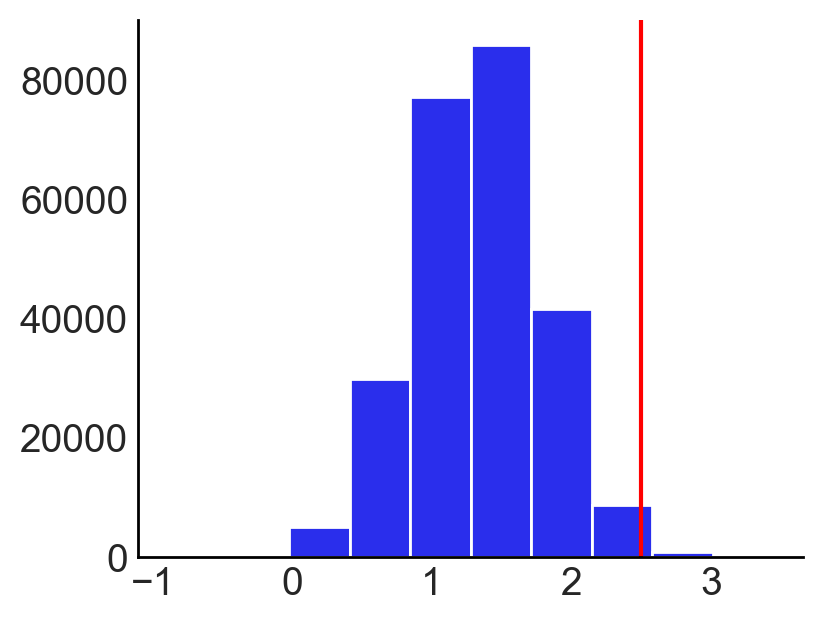

In [412]:
def q025(x):
    return x.quantile(.025)

def q975(x):
    return x.quantile(.975)

def q005(x):
    return x.quantile(.005)

def q995(x):
    return x.quantile(.995)

print(twostage_post_samp_jit.shape)
# print(twostage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:",1)
print(twostage_post_samp_jit.agg(['mean','std','median',q005,q025, q975, q995,'min','max']))

plt.figure(figsize=(4,3))
plt.hist(twostage_post_samp_jit["alpha_2"])
plt.axvline(x=alpha[2], color="red")
# plt.scatter(twostage_post_samp["alpha_2"],twostage_post_samp["alpha_3"])

# TODO: check what is going on in here... we obtain weird results for alpha_2

In [409]:
# Three-stage: for each A* and A|A* param, sample one A*, and sample one (or more) outcome models
def threestage_estimator(MCMC_obj, net_post_samples, Y, Z, X, n, i):

    # sample network
    curr_Astar = triu_to_mat(net_post_samples[i,], n)
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i),Y=Y,Z=Z,X=X,A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()

    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)


def threestage_jj(triu_post_samp, Y, Z, X, i):
    # sample network
    # curr_Astar = triu_to_mat(triu_post_samp, NN)
    curr_Astar = Triu_to_mat(triu_post_samp)
    # compute stats
      # expos = np.dot(curr_Astar,Z)
    cur_eigen_cen = eigen_centrality(curr_Astar)
    cur_Zeigen = jnp.dot(curr_Astar,Z*cur_eigen_cen)
    # expos, eigen_cen, between = compute_net_stats(np.array(curr_Astar), Z)
    # expos, eigen_cen, between = compute_net_stats(curr_Astar, jnp.array(Z))
    # get df
    # cur_df = np.transpose(np.array([[1]*NN,Z,expos,X,eigen_cen,between]))
    cur_df = np.transpose(np.array([[1]*NN,Z,cur_Zeigen,X]))
    # Run MCMC
    curr_posterior_samples = get_samples(random.PRNGKey(i), Y, cur_df)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
#      
# kernel_outcome = NUTS(outcome_model)
# # mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=1000, num_samples=100,num_chains=2, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 3000)

# print("starting parallel")
# start = time.time()
# threestage_post_samp = Parallel(n_jobs=8)(delayed(threestage_estimator)(mcmc_network_pred, post_predictive["triu_star"], Y, Z,x, n,i) for i in tqdm(i_range))
# threestage_post_samp = pd.concat(threestage_post_samp,axis=0)
# print(threestage_post_samp)
# print("No JIT time: ", time.time() - start)


K = 500
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
start = time.time()
threestage_post_samp_jit = pd.DataFrame()
for i in tqdm(i_range):
# for i in tqdm(range(Astar_post_shape[0])):
# for i in tqdm(range(Astar_post_shape[0])):
    cur_res = threestage_jj(post_predictive["triu_star"][i,], Y, Z, x, i)
    threestage_post_samp_jit = pd.concat([threestage_post_samp_jit, cur_res])    
print(threestage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)




100%|██████████| 500/500 [00:18<00:00, 26.96it/s]

     iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
0     655  0.979809 -0.768064  3.060637  0.917374 -0.248401
1     655  1.041941 -0.966525  2.940281  1.277748 -0.221841
2     655  1.041038 -0.819743  2.840548  1.609821 -0.212124
3     655  1.007937 -0.732928  2.858732  1.295661 -0.281766
4     655  0.988549 -0.739685  2.908058  0.849272 -0.270565
..    ...       ...       ...       ...       ...       ...
495  4020  1.001982 -0.754357  2.824593  1.670398 -0.243020
496  4020  1.008987 -0.688318  2.907000  2.117238 -0.249708
497  4020  1.036308 -0.690173  2.996544  2.004428 -0.241925
498  4020  1.020228 -0.760022  2.878670  1.783767 -0.253639
499  4020  0.962638 -0.771446  3.129928  1.464410 -0.243706

[250000 rows x 6 columns]
with JIT (non parallel) takes:  18.55332922935486


(250000, 6)
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 2.5', 'alpha_3 = -0.25'] sig: 1
                iter       sig   alpha_0   alpha_1   alpha_2   alpha_3
mean     8054.222000  1.011773 -0.737546  2.993674  1.330967 -0.248380
std      4691.178858  0.042458  0.125817  0.132918  0.497696  0.018919
median   8185.000000  1.010385 -0.735461  2.993905  1.311023 -0.248330
q005       97.000000  0.910218 -1.072594  2.651118  0.121836 -0.297363
q025      294.000000  0.932478 -0.989214  2.732942  0.406338 -0.285489
q975    15772.000000  1.098886 -0.496858  3.254438  2.372613 -0.211261
q995    15948.000000  1.129387 -0.421411  3.333963  2.742279 -0.199716
min        14.000000  0.843692 -1.332539  2.395986 -0.975203 -0.337543
max     15967.000000  1.238743 -0.186145  3.586950  3.905127 -0.162690


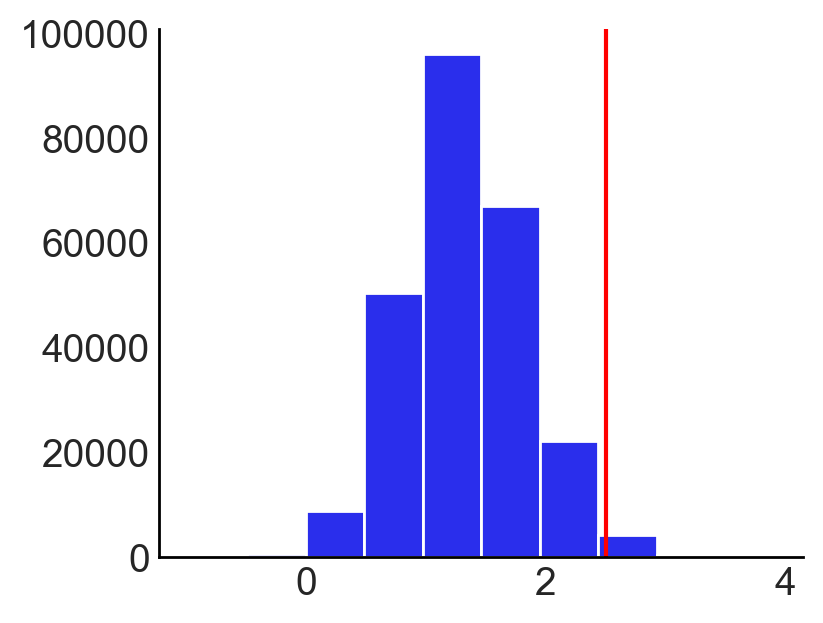

In [410]:
print(threestage_post_samp_jit.shape)
# print(threestage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:", 1)
threestage_post_samp_agg = threestage_post_samp_jit.agg(['mean','std','median',q005,q025, q975,q995,'min','max'])
print(threestage_post_samp_agg)

plt.figure(figsize=(4,3))
plt.hist(threestage_post_samp_jit["alpha_2"])
plt.axvline(x=alpha[2], color="red")

In [377]:
print(threestage_post_samp_agg["alpha_2"]["mean"])
dict_3S = threestage_post_samp_agg["alpha_2"].to_dict()
print(dict_3S)
dict_3S["var_MI"] = 3
print(dict_3S)
dict_3S = {k : dict_3S[k] for k in ["mean","median","var_MI","q025","q975","min","max"]}
print(pd.DataFrame(dict_3S, index = [0]))


1.3326679468154907
{'mean': 1.3326679468154907, 'std': 0.49662595987319946, 'median': 1.3153936862945557, 'q005': 0.11228351827710867, 'q025': 0.40402726009488105, 'q975': 2.3632354736328125, 'q995': 2.7137237441539765, 'min': -0.8975401520729065, 'max': 3.5746750831604004}
{'mean': 1.3326679468154907, 'std': 0.49662595987319946, 'median': 1.3153936862945557, 'q005': 0.11228351827710867, 'q025': 0.40402726009488105, 'q975': 2.3632354736328125, 'q995': 2.7137237441539765, 'min': -0.8975401520729065, 'max': 3.5746750831604004, 'var_MI': 3}
       mean    median  var_MI      q025      q975      min       max
0  1.332668  1.315394       3  0.404027  2.363235 -0.89754  3.574675


In [413]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



VB:  0.09206136577353925 VW:  0.1561357  Total var:  0.24838118169756834  Naive var:  0.24770068


In [380]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).
def onestage_estimator(net_post_samples, Z, n, i_range):
    
    deg_list = []
    # sum_expos_list = []
    expos_list = []
    eig_cen_list = []
    Zeigen_list = []
    
    for i in i_range:
        # sample network
        # curr_Astar = triu_to_mat(net_post_samples[i,], n)
        curr_Astar = Triu_to_mat(net_post_samples[i,])
        # compute stat
        # expos, eig_cen, between = compute_net_stats(curr_Astar, Z)
        
        # save statistics
        # c_deg = np.sum(curr_Astar,1)
        # c_sum_expos = np.dot(curr_Astar, Z)
        # c_expos = np.where(np.equal(c_deg,0),0,c_sum_expos/c_deg)
        
        deg_list.append([jnp.sum(curr_Astar,1)])
        expos_list.append([jnp.dot(curr_Astar, Z)])
        
        cur_eig_cen = eigen_centrality(curr_Astar)
        eig_cen_list.append([cur_eig_cen])
        Zeigen_list.append([jnp.dot(curr_Astar, Z*cur_eig_cen)])
        
               
        # deg_list.append([c_deg])
        # sum_expos_list.append([c_sum_expos])
        # expos_list.append([c_expos])
        if i == max(i_range)//2:
            print("mid way")
    
    return {'deg' : deg_list,
            # 'sum_expos' : sum_expos_list,
            'expos' : expos_list,
            'eig_cen' : eig_cen_list,
            'Zeigen' : Zeigen_list}
        
# i_range = np.random.randint(low=0, high=post_predictive["triu_star"].shape[0],size =5000)
start = time.time()
onestage_net_stat = onestage_estimator(post_predictive["triu_star"], Z, n, range(post_predictive["triu_star"].shape[0]))
print(time.time() - start)
# onestage_net_stat = Parallel(n_jobs=8)(delayed(onestage_estimator)(post_predictive["triu_star"], Z, n,i) for i in tqdm(i_range))
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=1000,num_chains=1, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 1000)


mid way
50.55599308013916


deg corr 0.8194728405534986
expos corr 0.7237344533187836
zeigen corr 0.7647859703555872


Text(0, 0.5, 'True Zeigen')

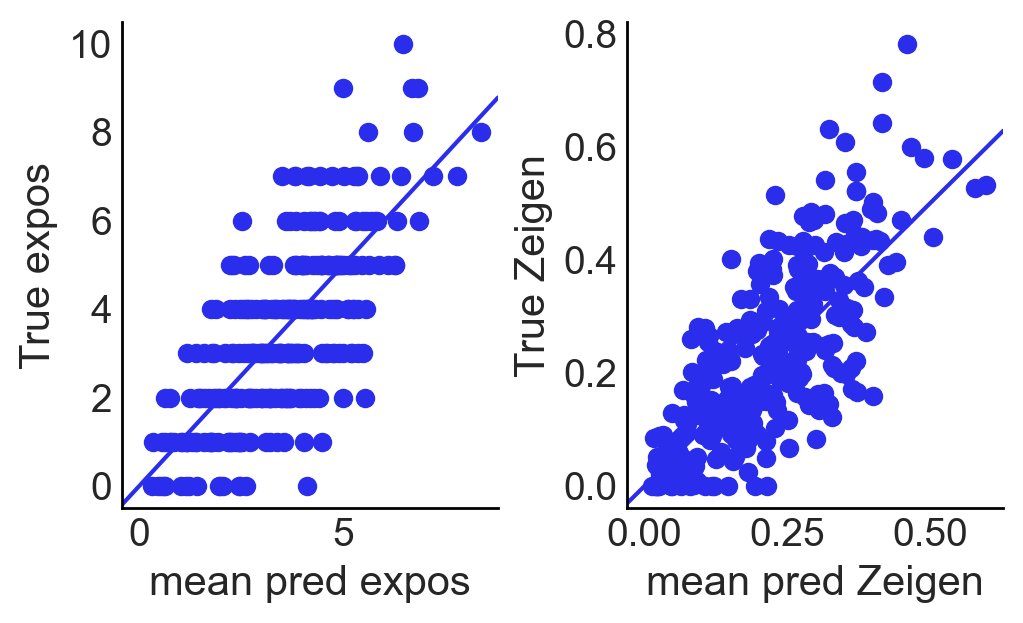

In [383]:
mean_deg = np.mean(onestage_net_stat["deg"],axis=0)
mean_expos = np.mean(onestage_net_stat["expos"],axis=0)
mean_eig_cen = np.mean(onestage_net_stat["eig_cen"],axis=0)
mean_Zeigen = np.mean(onestage_net_stat["Zeigen"],axis=0)

# mean_sum_expos = np.mean(onestage_net_stat["sum_expos"],axis=0)

print("deg corr", np.corrcoef(mean_deg,degrees)[1,0])
print("expos corr", np.corrcoef(mean_expos,exposures)[1,0])
print("zeigen corr", np.corrcoef(mean_Zeigen,Zeigen)[1,0])
# print("expos (hat) corr Y", np.corrcoef(mean_expos,Y)[1,0])
# print("expos (true) corr Y", np.corrcoef(exposures,Y)[1,0])

fig, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize = (5,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
# ax1.scatter(mean_deg, np.sum(mat,1), marker = 'o')
ax1.scatter(mean_expos,exposures, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(mean_Zeigen, Zeigen,)
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred expos")
ax2.set_xlabel("mean pred Zeigen")
ax1.set_ylabel("True expos")
ax2.set_ylabel("True Zeigen")


In [396]:
np.transpose(np.array(mean_Zeigen))[:,:].shape

(300, 1)

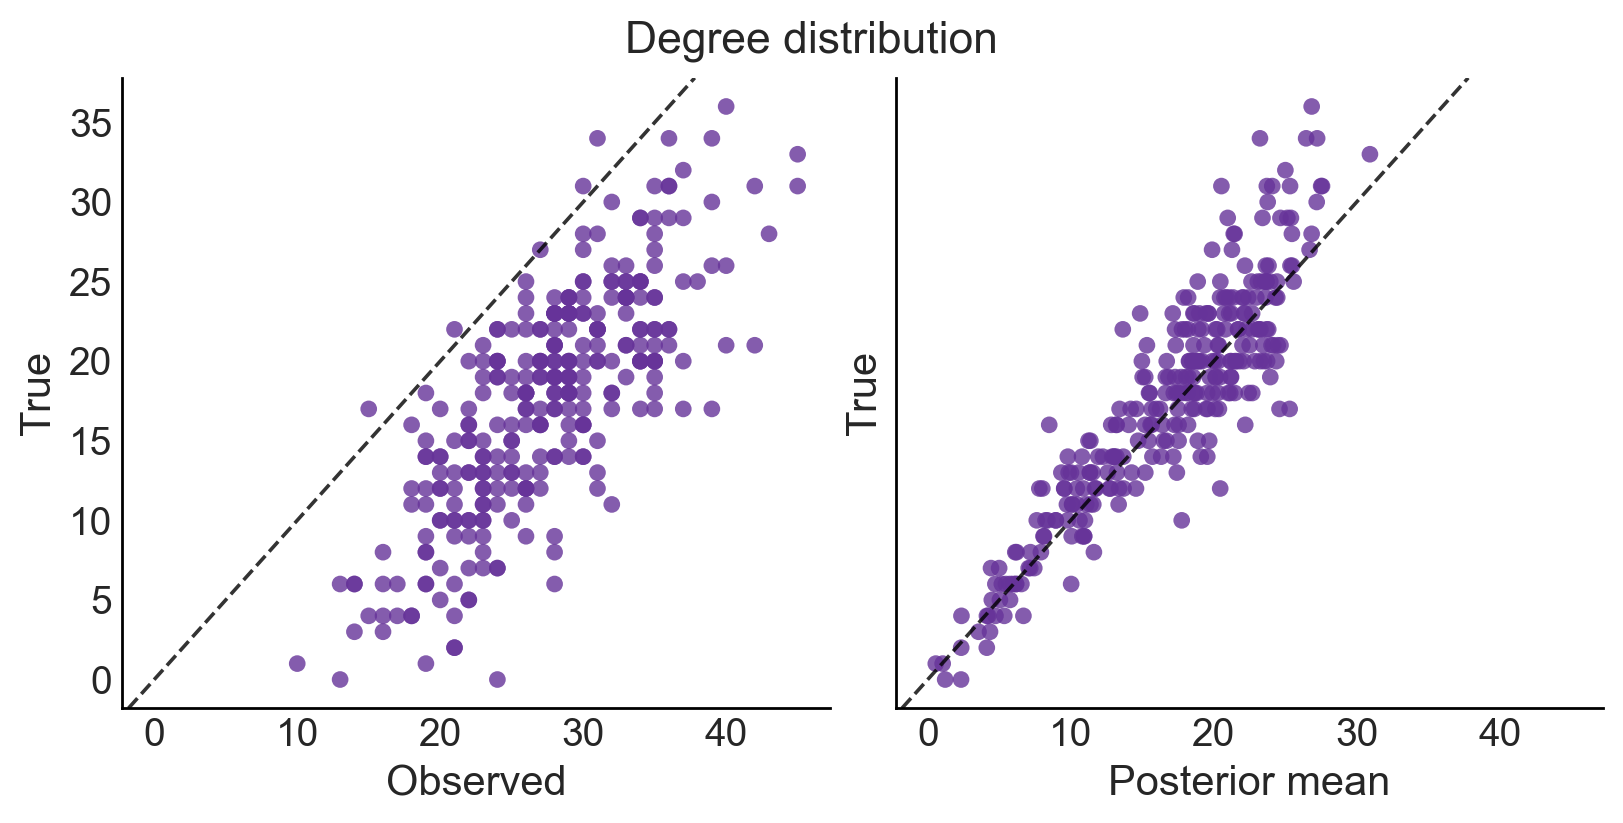

In [31]:

true_deg = np.sum(mat,1)
obs_deg = np.sum(obs_mat,1)

beige_color = '#FFFDFA'
pastel_purple_dark = (0.4, 0.2, 0.6)
# sns.set_theme(style="ticks", rc={'figure.facecolor': beige_color, 'axes.facecolor' : beige_color})
# sns.set_context("poster")


fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
# fig.patch.set_facecolor(beige_color)
# for ax in axes:
    # ax.set_facecolor(beige_color) 

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(x=obs_deg,y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax1.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(x=mean_deg, y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax2.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
ax2.set_xlabel("Posterior mean")
ax1.set_xlabel("Observed")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

fig.suptitle('Degree distribution', fontsize=16)

fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('deg_dist.png', dpi=300)

Text(0, 0.5, 'True')

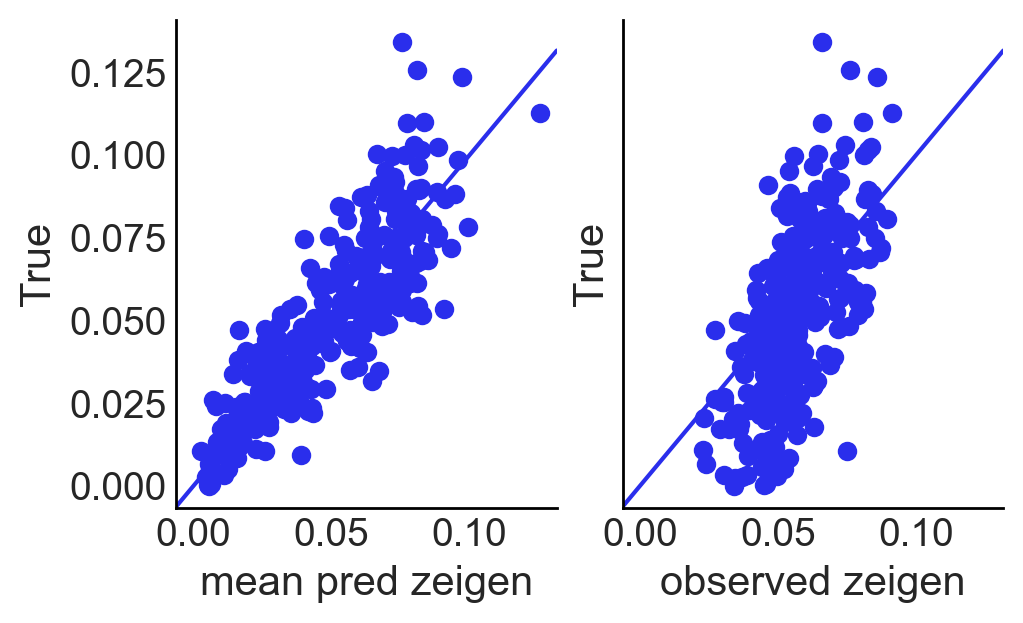

In [386]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True, figsize = (5,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
# ax1.scatter(mean_expos, exposures, c = Z, marker = 'o')
# ax1.scatter(mean_Zeigen, Zeigen, marker = 'o')
ax1.scatter(mean_eig_cen, eigen_center, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.scatter(obs_exposures, exposures,c = Z, marker = 'o')
ax2.scatter(obs_eigen_cent, eigen_center,marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred zeigen")
ax2.set_xlabel("observed zeigen")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

In [407]:

mean_Zeigen = np.reshape(mean_Zeigen, (300,))
one_stage_df = np.transpose(np.array([[1]*n, Z, mean_Zeigen, x]))

In [408]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
kernel_stat_outcome = NUTS(outcome_model)
mcmc_network_stat = MCMC(kernel_stat_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_stat.run(rng_key_,Y=Y,X=one_stage_df)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_stat.print_summary()
samples_network_stat = mcmc_network_stat.get_samples()
print(time.time() - start)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.95      0.13     -0.95     -1.16     -0.74  10201.57      1.00
  alpha[1]      3.01      0.13      3.02      2.80      3.22  12945.48      1.00
  alpha[2]      2.26      0.49      2.26      1.47      3.08  10974.53      1.00
  alpha[3]     -0.25      0.02     -0.25     -0.28     -0.22  14459.23      1.00
       sig      1.00      0.04      1.00      0.93      1.06  14837.48      1.00

Number of divergences: 0
8.202239513397217
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 2.5', 'alpha_3 = -0.25'] sig: 1


In [339]:
# dims = {"X": ["time"], "TriU": ["time"]}
# idata_kwargs = {"dims": dims, "constant_data": {"X": x_diff, "TriU": triu_obs}}
# trace_data = az.from_numpyro(mcmc, **idata_kwargs)
# trace_data = az.from_numpyro(posterior=mcmc_network, posterior_predictive=post_predictive,)
# display(trace_data)
# az.plot_trace(trace_data, compact=True)

In [340]:
# posterior_mu = jnp.expand_dims(samples["beta0"],-1) + jnp.expand_dims(samples["beta1"],-1)*x_diff

# print(posterior_mu.shape)
# print(posterior_mu[0:5,0:5])

# fix, ax = plt.subplots(nrows=1,ncols=1, figsize = (5,5))
# ax.plot(beta[0] + beta[1]*x_diff, posterior_mu.mean(axis=0), "o")


In [341]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_triu = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_triu].set(triu) 
    return adj_mat + adj_mat.T

def model_discrete(Y, Z, X, TriU, n):
    # Network model
    beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    mu_net = beta_0 + beta_1*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    
    # temp = numpyro.sample("temp", dist.Uniform(low=0,high=1))
    
    with numpyro.plate("A* and A",triu_n):
        # logp of A* 
        triu_star = numpyro.sample("triu_star",dist.BernoulliLogits(logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=.5,logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=temp,logits=mu_net))
        # # logp of A|A*
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        # prob_misspec = jnp.where(tril_star==1, 1-gamma1, gamma0)
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
       
    # get Astar the symmetric matrix from lower triangle values `tril_var`
    Astar = numpyro.deterministic("Astar", triu_to_mat(triu_star,n))
    # Compute exposures (Astar*Z / d)
    degrees = jnp.sum(Astar,1)
    # num_expos = jnp.dot(Astar,Z)
    # expos = numpyro.deterministic("expos", jnp.where(degress==0,0,num_expos/degrees))
    expos = numpyro.deterministic("expos", jnp.nan_to_num(jnp.dot(Astar,Z)/jnp.sum(Astar,1),nan=0.0))
       
    
    # Outcome model
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    sig = numpyro.sample("sig", dist.Exponential(0.5))
    mu = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*degrees
    with numpyro.plate("n",n):
        numpyro.sample("Y",dist.Normal(mu,sig),obs=Y)
        
    
        


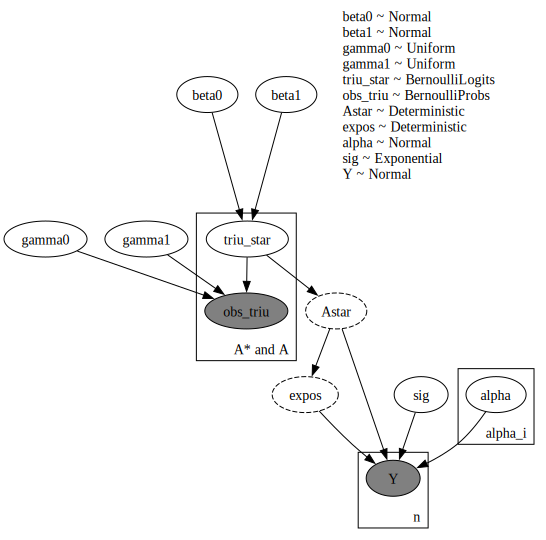

In [342]:
numpyro.render_model(model_discrete, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)


In [343]:
# # Sample from relaxed model
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# # kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model_relaxed)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc.print_summary()
# samples = mcmc.get_samples()
# print(time.time() - start)

In [344]:
print("beta 0:", beta[0], "beta1:", beta[1], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)


beta 0: -2.5 beta1: -0.5 gamma0: 0.049999999999999996 gamma1: 0.3
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [345]:
# Sample from discrete model with mixedHMC
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.2), num_discrete_updates=tril_dim//6)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=1000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [346]:
# Sample from discrete model with NwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [347]:
# Sample from discrete model with HwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(HMC(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)